# Sales  Forecasting  -->  Future Sales Prediction

In [2]:
# Importing required libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape, test.shape

((2935849, 6), (214200, 3))

In [5]:
# Extraacting info :
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
# Check for null and duplicate vals :
print('null vals : ' , train.isnull().sum())
print('duplicates : ', train.duplicated)

null vals :  date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
duplicates :  <bound method DataFrame.duplicated of                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       2

In [10]:
train.dtypes, test.columns

(date               object
 date_block_num      int64
 shop_id             int64
 item_id             int64
 item_price        float64
 item_cnt_day      float64
 dtype: object,
 Index(['ID', 'shop_id', 'item_id'], dtype='object'))

In [11]:
# Now extract the monthly data :
monthly_data = train.pivot_table(
    index = ['shop_id','item_id'],
    values = ['item_cnt_day'],
    columns = ['date_block_num'],
    fill_value = 0,
    aggfunc='sum')

In [12]:
monthly_data.head(10)

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        36                 0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        40                 0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        42                 0   1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        43                 1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        49                 0   2  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
        36       0  0  0  0  0  
        40       0  0  0  0  0  
        42       0  0  0  0  0  
        43       0  0  0  0  0  
        49       0  0  0  0  0  

[10 rows x 34 columns]

In [13]:
monthly_data.reset_index(inplace = True)
monthly_data.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [15]:
# Dropo the unwanted cols :
train_data = monthly_data.drop(columns= ['shop_id','item_id'], level=0)
train_data.head()

item_cnt_day                              ...                 \
date_block_num           0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
0                         0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                               
date_block_num 29 30 31 32 33  
0               0  0  0  0  0  
1               0  0  0  0  0  
2               0  0  0  0  0  
3               0  0  0  0  0  
4               0  0  0  0  0  

[5 rows x 34 columns]

In [16]:
train_data.fillna(0,inplace = True)
train_data.head()

item_cnt_day                              ...                 \
date_block_num           0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
0                         0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                               
date_block_num 29 30 31 32 33  
0               0  0  0  0  0  
1               0  0  0  0  0  
2               0  0  0  0  0  
3               0  0  0  0  0  
4               0  0  0  0  0  

[5 rows x 34 columns]

In [17]:
x_train = np.expand_dims(train_data.values[:,:-1],axis = 2)
y_train = train_data.values[:,-1:]

In [18]:
test_rows = monthly_data.merge(
    test,
    on = ['item_id','shop_id'],
    how = 'right')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [19]:
test_rows.head()

,item_id,shop_id,"(shop_id, )","(item_id, )","(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)",...,"(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)",ID
0,5037,5,5.0,5037.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0
1,5320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,5233,5,5.0,5233.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2
3,5232,5,5.0,5232.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
4,5268,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [21]:
x_test = test_rows.drop(test_rows.columns[:5], axis=1).drop('ID', axis=1)
x_test

,"(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#  as we can see there are many NaN vals , so fill them with 0 :
x_test.fillna(0,inplace = True)
x_test.head()

,"(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
x_test = np.expand_dims(x_test,axis = 2)
print(x_train.shape,y_train.shape,x_test.shape)

(424124, 33, 1) (424124, 1) (214200, 33, 1)


In [25]:
# Now build our model :
model = tf.keras.models.Sequential()    
model.add(LSTM(64, input_shape=(33, 1), return_sequences=False))
model.add(Dense(1))
    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

In [26]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=4096,
    verbose=1, 
    shuffle=True,
    validation_split=0.4)

Epoch 1/10
63/63 [==============================] - 97s 1s/step - loss: 24.7566 - mean_squared_error: 24.7566 - val_loss: 2.5596 - val_mean_squared_error: 2.5596
Epoch 2/10
63/63 [==============================] - 96s 2s/step - loss: 24.5507 - mean_squared_error: 24.5507 - val_loss: 2.4732 - val_mean_squared_error: 2.4732
Epoch 3/10
63/63 [==============================] - 86s 1s/step - loss: 24.4392 - mean_squared_error: 24.4392 - val_loss: 2.4314 - val_mean_squared_error: 2.4314
Epoch 4/10
63/63 [==============================] - 87s 1s/step - loss: 24.3689 - mean_squared_error: 24.3689 - val_loss: 2.4045 - val_mean_squared_error: 2.4045
Epoch 5/10
63/63 [==============================] - 83s 1s/step - loss: 24.3293 - mean_squared_error: 24.3293 - val_loss: 2.7821 - val_mean_squared_error: 2.7821
Epoch 6/10
63/63 [==============================] - 83s 1s/step - loss: 24.3023 - mean_squared_error: 24.3023 - val_loss: 2.3778 - val_mean_squared_error: 2.3778
Epoch 7/10
63/63 [==========

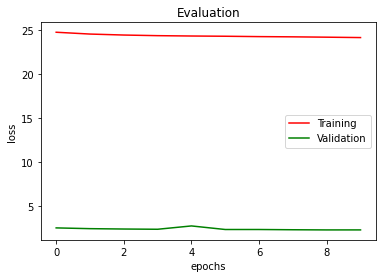

In [27]:
plt.plot(history.history["loss"], color="r")
plt.plot(history.history["val_loss"], color="g")
plt.legend(["Training", "Validation"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Evaluation')
plt.show()

In [28]:
test_predict = model.predict(x_test)

6694/6694 [==============================] - 80s 10ms/step


In [29]:
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':test_predict.ravel()})
submission['item_cnt_month'] = submission['item_cnt_month']
submission.to_csv('submission.csv',index = False)